<a href="https://colab.research.google.com/github/motoroko/machinelearning/blob/master/TUBESMALIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering



 Import Library

In [0]:
import numpy as np 
import pandas as pd
import io
import random
import math
from google.colab import files
import matplotlib.pyplot as plt
from scipy.spatial import distance
from collections import Counter

 Import Dataset

In [2]:
uploaded = files.upload()

Saving air_bnb.csv to air_bnb.csv


 Dataset Preprocessing

In [3]:
df = pd.read_csv(io.BytesIO(uploaded['air_bnb.csv']))
df.shape

(22552, 16)

Missing Value Problem

In [4]:
# Checking the size of the row with complete value
df_training = df.dropna()
print(df_training.shape)
print( np.round((df_training.shape[0]/df.shape[0]) * 100,2), '%') 

(18587, 16)
82.42 %


In [5]:
# Checking the size of the row with missing value
df_qual = df[df.isnull().any(axis='columns')]
print(df_qual.shape[0])
print( np.round((df_qual.shape[0]/df.shape[0]) * 100,2), '%') 

3965
17.58 %


In [6]:
df_training.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ian,Mitte,Brunnenstr. Süd,52.534537,13.402557,Entire home/apt,60,4,118,2018-10-28,3.76,4,141
1,2695,Prenzlauer Berg close to Mauerpark,2986,Michael,Pankow,Prenzlauer Berg Nordwest,52.548513,13.404553,Private room,17,2,6,2018-10-01,1.42,1,0
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.534996,13.417579,Entire home/apt,90,62,143,2017-03-20,1.25,1,220
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.498855,13.349065,Private room,26,5,25,2018-08-16,0.39,1,297
4,7071,BrightRoom with sunny greenview!,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,42,2,197,2018-11-04,1.75,1,26


In [7]:
df_training.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,1.858700e+04,1.858700e+04,18587.000000,18587.000000,18587.000000,18587.000000,18587.000000,18587.000000,18587.000000,18587.000000
mean,1.529028e+07,5.192363e+07,52.509923,13.406351,61.990961,6.536127,21.617690,1.138112,1.933502,84.334320
std,8.456565e+06,5.660290e+07,0.030543,0.057249,145.874539,43.156393,39.464083,1.508100,3.766036,120.513906
min,2.015000e+03,2.217000e+03,52.345803,13.103557,0.000000,1.000000,1.000000,0.010000,1.000000,0.000000
25%,7.797145e+06,8.579471e+06,52.489195,13.376423,30.000000,2.000000,3.000000,0.180000,1.000000,0.000000
50%,1.643876e+07,2.892871e+07,52.509208,13.416857,46.000000,2.000000,7.000000,0.540000,1.000000,8.000000
75%,2.218477e+07,7.724873e+07,52.532653,13.439131,70.000000,4.000000,21.000000,1.510000,1.000000,145.000000
max,2.984956e+07,2.242958e+08,52.641499,13.757642,8600.000000,5000.000000,498.000000,36.670000,45.000000,365.000000


In [8]:
dfclust = pd.DataFrame(data=[])
dfclust['neighbourhood'] = df_training['neighbourhood'] 
dfclust['number_of_reviews'] = df_training['number_of_reviews']
#dfclust['class'] = np.zeros((dfclust.shape[0],1)).astype('int64')

dfclust

,neighbourhood,number_of_reviews
0,Brunnenstr. Süd,118
1,Prenzlauer Berg Nordwest,6
2,Prenzlauer Berg Südwest,143
3,Schöneberg-Nord,25
4,Helmholtzplatz,197
...,...,...
22449,Neu Lichtenberg,1
22463,Oberschöneweide,5
22475,Frankfurter Allee Süd FK,1
22508,Prenzlauer Berg Nordwest,1


Categorical Encoding

In [9]:
def delduplicate(a):
  b = a
  return list(Counter(b))

key = []

for i in dfclust.columns:
  key.append(delduplicate(dfclust[i]))

for i in range(len(dfclust.columns)):
  if dfclust[dfclust.columns[i]].dtypes != 'int64' and dfclust[dfclust.columns[i]].dtypes != 'float64':
    for j in range(len(dfclust)):
      k = key[i]
      for l in range(len(k)):
        if dfclust[dfclust.columns[i]].iloc[j] == k[l]:
          dfclust[dfclust.columns[i]].iloc[j] = l+1
          break

dfclust

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,neighbourhood,number_of_reviews
0,1,118
1,2,6
2,3,143
3,4,25
4,5,197
...,...,...
22449,51,1
22463,117,5
22475,11,1
22508,2,1


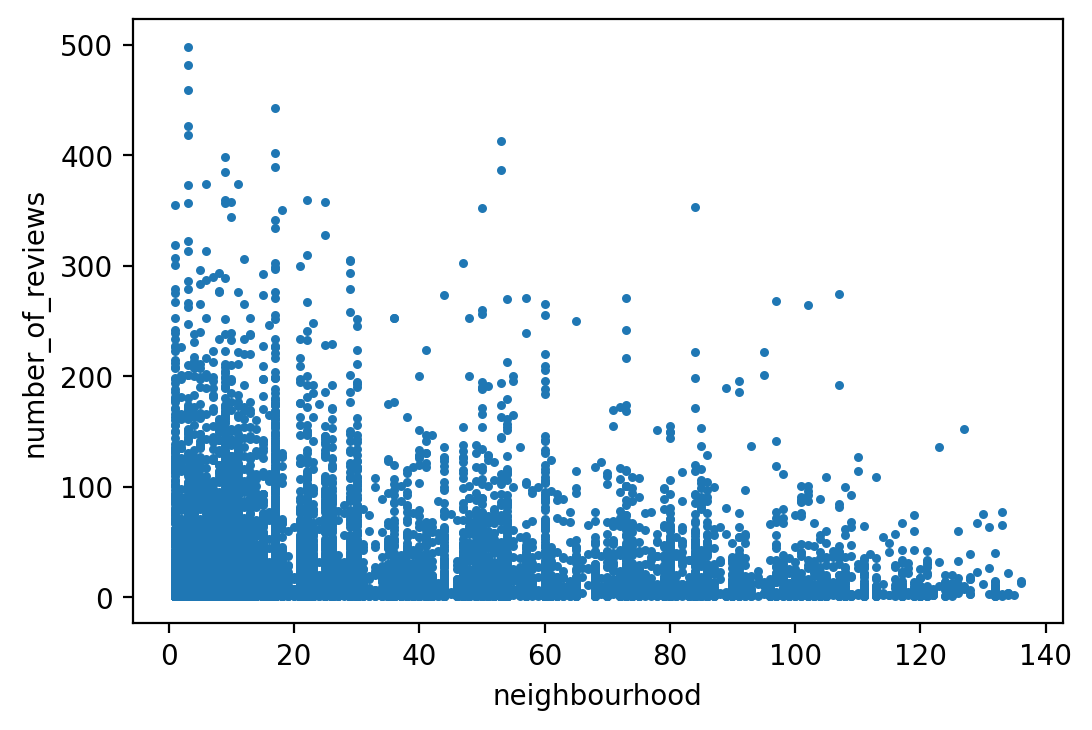

In [10]:
plt.figure(dpi=200)
plt.scatter(dfclust['neighbourhood'],dfclust['number_of_reviews'],s=5)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.show()

MinMax Scalling

In [11]:
for i in dfclust.columns:
  for j in range(len(dfclust[i])):
    dfclust[i].iloc[j] = ( dfclust[i].iloc[j] - min(dfclust[i]) ) / ( max(dfclust[i]) - min(dfclust[i]) )

dfclust

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,neighbourhood,number_of_reviews
0,0,0.235412
1,0.0147059,0.011581
2,0.0220588,0.287132
3,0.0294118,0.050179
4,0.0367647,0.395568
...,...,...
22449,0.435897,0.199682
22463,1,1.000000
22475,1,0.499503
22508,0.666667,0.499503


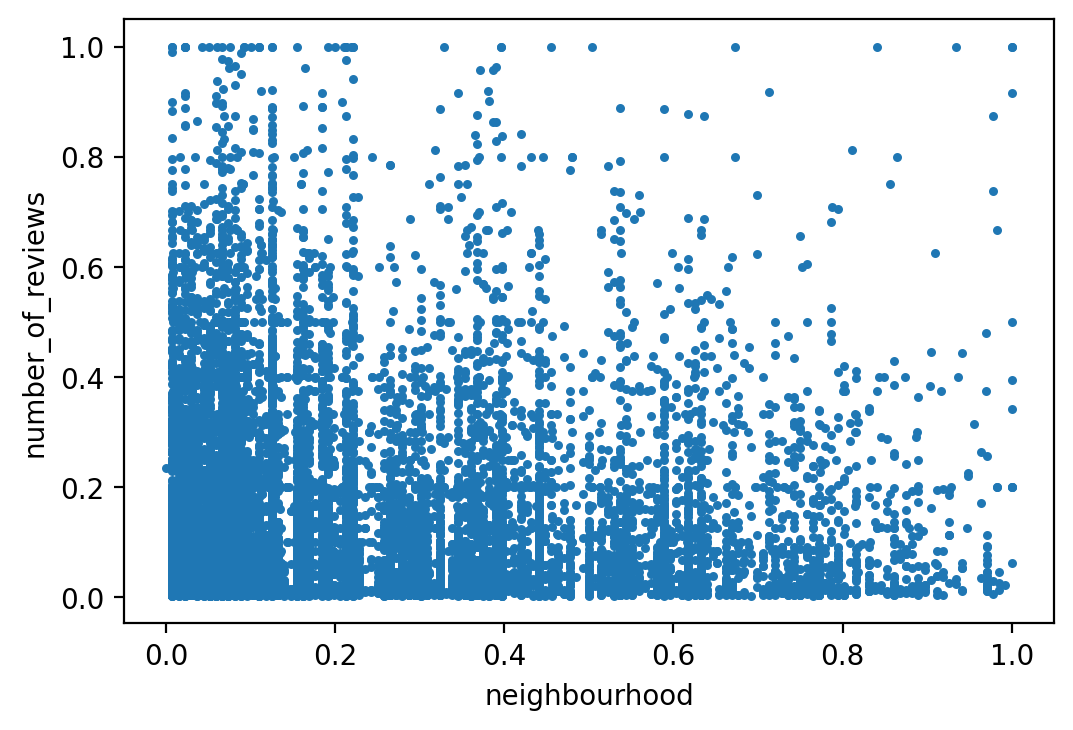

In [12]:
plt.figure(dpi=200)
plt.scatter(dfclust['neighbourhood'],dfclust['number_of_reviews'],s=5)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.show()

 Elbow Method

In [0]:
numberOfK , distortions = [],[]

for entity in range(2,16):
  k = entity

  df1 = dfclust['neighbourhood']
  df2 = dfclust['number_of_reviews']

  newX , newY = [],[]

  for i in range(k):
    newX.append(df1.sample().values)
    newY.append(df2.sample().values)
  
  df3 = pd.Series(newX)
  df4 = pd.Series(newY)

  newCentroidX = newX
  newCentroidY = newY

  same = False
  while ( not same ):
    zonex,zoney = [],[]
    for i in range(k):
      zonex.append([])
      zoney.append([])

    x1 = newCentroidX
    y1 = newCentroidY

    for i in range(len(df1)):
      dist = []
      for j in range(k):
        dist.append(math.sqrt(((x1[j] - df1.iloc[i])**2) + ((y1[j] - df2.iloc[i])**2)))

      for j in range(len(dist)):
        if dist[j] == min(dist):
          zonex[j].append(df1.iloc[i])
          zoney[j].append(df2.iloc[i])
          break

    newCentroidX,newCentroidY = [],[]

    #new centroid
    for i in range(k):
      newCentroidX.append(sum(zonex[i])/len(zonex[i]))
      newCentroidY.append(sum(zoney[i])/len(zonex[i]))

    df3 = pd.Series(newCentroidX)
    df4 = pd.Series(newCentroidY)

    for i in range(k):
      if newCentroidX[i] == x1[i] and newCentroidY[i] == y1[i]:
        same = True

  centers = np.array(list(zip(df3, df4))).reshape(len(df3), 2)
  distortions.append(sum(np.min(distance.cdist(dfclust, centers, 'euclidean'), axis=1)) / centers.shape[0])
  numberOfK.append(k)


In [0]:
plt.figure(dpi=150)
plt.plot(numberOfK,distortions, 'bo--')
plt.xlabel('Number Of K')
plt.ylabel('Distortions')
plt.show()

Cluster with centroid randomly pick array sample

In [0]:
k = 3

print('K Value is ', k)

df1 = dfclust['neighbourhood']
df2 = dfclust['number_of_reviews']

newX , newY = [],[]

for i in range(k):
  newX.append(df1.sample().values)
  newY.append(df2.sample().values)

df3 = pd.Series(newX)
df4 = pd.Series(newY)

plt.figure(dpi=150)
plt.scatter(df1,df2,c='b',marker='x',label='location',s=5)
plt.scatter(df3,df4,c='r',marker='s',label='Centroid',s=5)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.legend()
plt.show()

newCentroidX = newX
newCentroidY = newY

same = False

print("start looping")
while ( not same ):
  zonex,zoney = [],[]
  for i in range(k):
    zonex.append([])
    zoney.append([])

  x1 = newCentroidX
  y1 = newCentroidY

  for i in range(len(df1)):
    dist = []
    for j in range(k):
      dist.append(math.sqrt(((x1[j] - df1.iloc[i])**2) + ((y1[j] - df2.iloc[i])**2)))

    for j in range(len(dist)):
      if dist[j] == min(dist):
        #dfclust['class'].iloc[i] = j+1
        zonex[j].append(df1.iloc[i])
        zoney[j].append(df2.iloc[i])
        break

  newCentroidX,newCentroidY = [],[]

  #new centroid
  for i in range(k):
    newCentroidX.append(sum(zonex[i])/len(zonex[i]))
    newCentroidY.append(sum(zoney[i])/len(zonex[i]))

  df3 = pd.Series(newCentroidX)
  df4 = pd.Series(newCentroidY)

  for i in range(k):
    if newCentroidX[i] == x1[i] and newCentroidY[i] == y1[i]:
      same = True

plt.figure(dpi=150)
for i in range(k):
  plt.scatter(zonex[i],zoney[i],marker='x',label='cluster '+str(i),s=5)
plt.scatter(df3,df4,c='black',label='Centroid',s=10)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.legend(fontsize='small')
plt.show()

print("end looping")

Cluster with centroid use random number in between min and max value of each array

In [0]:
k = 3

print('K Value is ', k)

df1 = dfclust['neighbourhood']
df2 = dfclust['number_of_reviews']

newX , newY = [],[]

for i in range(k):
  newX.append(random.uniform(min(df1),max(df1)))
  newY.append(random.uniform(min(df2),max(df2)))

df3 = pd.Series(newX)
df4 = pd.Series(newY)

plt.figure(dpi=150)
plt.scatter(df1,df2,c='b',marker='x',label='location',s=5)
plt.scatter(df3,df4,c='r',marker='s',label='Centroid',s=5)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.legend()
plt.show()

newCentroidX = newX
newCentroidY = newY

same = False

print("start looping")
while ( not same ):
  zonex,zoney = [],[]
  for i in range(k):
    zonex.append([])
    zoney.append([])

  x1 = newCentroidX
  y1 = newCentroidY

  for i in range(len(df1)):
    dist = []
    for j in range(k):
      dist.append(math.sqrt(((x1[j] - df1.iloc[i])**2) + ((y1[j] - df2.iloc[i])**2)))

    for j in range(len(dist)):
      if dist[j] == min(dist):
        #dfclust['class'].iloc[i] = j+1
        zonex[j].append(df1.iloc[i])
        zoney[j].append(df2.iloc[i])
        break

  newCentroidX,newCentroidY = [],[]

  #new centroid
  for i in range(k):
    newCentroidX.append(sum(zonex[i])/len(zonex[i]))
    newCentroidY.append(sum(zoney[i])/len(zonex[i]))
    
  df3 = pd.Series(newCentroidX)
  df4 = pd.Series(newCentroidY)

  for i in range(k):
    if newCentroidX[i] == x1[i] and newCentroidY[i] == y1[i]:
      same = True

plt.figure(dpi=150)
for i in range(k):
  plt.scatter(zonex[i],zoney[i],marker='x',label='cluster '+str(i),s=5)
plt.scatter(df3,df4,c='black',label='Centroid',s=10)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.legend(fontsize='small')
plt.show()

print("end looping")

# Classification

Import library

In [0]:
%matplotlib inline

from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras import layers
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler 
from matplotlib.colors import ListedColormap

In [0]:
df = pd.read_csv(io.BytesIO(uploaded['air_bnb.csv']))
df.shape

In [0]:
df2 = df[['neighbourhood','price','room_type']]
df2

In [0]:
def delduplicate(a):
  b = a
  return list(Counter(b))

key = []

for i in df2.columns:
  key.append(delduplicate(df2[i]))

for i in range(len(df2.columns)):
  if df2[df2.columns[i]].dtypes != 'int64' and df2[df2.columns[i]].dtypes != 'float64':
    for j in range(len(df2)):
      k = key[i]
      for l in range(len(k)):
        if df2[df2.columns[i]].iloc[j] == k[l]:
          df2[df2.columns[i]].iloc[j] = l+1
          break

df2

In [0]:
for i in df2.columns:
  median = df2[i].median()
  df2[i].fillna(median, inplace=True)

df2

In [0]:
clean_data = df2.to_numpy()

In [0]:
train, test = train_test_split(clean_data, test_size=0.2)
print(len(train), 'train examples')
print(len(test), 'test examples')

In [0]:
train_data = np.copy(train)
test_data = np.copy(test)
y_train = train[:,-1]
X_train = train_data[:,:-1]
y_test = test[:,-1]
x_test = test_data[:,:-1]
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [0]:
st_x= StandardScaler()    
X_train= st_x.fit_transform(X_train)    
x_test= st_x.transform(x_test)

KNN Classifier

In [0]:
classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
classifier.fit(X_train, y_train)

In [0]:
y_pred = classifier.predict(x_test)
print(y_pred)

In [0]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(" Accuracy: ",accuracy_score(y_test, y_pred))
print(" F1 score: ",metrics.f1_score(y_test, y_pred,average='weighted'))

In [0]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [0]:
#Visulaizing the training set result  
plt.figure(dpi=150)
x_set, y_set = X_train, y_train  
x1, x2 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step  =0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x2, classifier.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape),  
alpha = 0.5, cmap = ListedColormap(('red','green','blue' )))
plt.xlim(x1.min(), x1.max())  
plt.ylim(x2.min(), x2.max())  
for i, j in enumerate(np.unique(y_set)):  
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],  
        c = ListedColormap(('red', 'green','blue'))(i), label = j)  
plt.title('K-NN Algorithm (Training set)')  
plt.xlabel('neighbourhood')  
plt.ylabel('price')  
plt.legend()  
plt.show()  

SVM Classifier

In [0]:
train_data = np.copy(train)
test_data = np.copy(test)
y_train = train[:,-1]
X_train = train_data[:,:-1]
y_test = test[:,-1]
x_test = test_data[:,:-1]
y_train = y_train.astype(int)
y_test = y_test.astype(int)

Linier Kernel

In [0]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Polynomial Kernel

In [0]:
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Gaussian Kernel

In [0]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Sigmoid Kernel

In [0]:
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))